# Prediccón de gastos medicos

Para utilizar este notebook seguir los pasos listados a continuación:
1. Descargar dataset desde Kaggle ([Medical Cost Personal Dataset](https://www.kaggle.com/datasets/mirichoi0218/insurance?select=insurance.csv))
2. Descomprimir el arhcivo `.zip`
3. Colocar el archivo `insurance.csv` en la carpeta `data/raw`


Columnas (variables) del dataset:
- `age`: Edad del asegurado
- `sex`: Género binario del asegurado
- `bmi`: Indice de masa corporal
- `children`: Cantidad de hijos
- `smoker`: Si el paciente es fumador o no fumador
- `region`: Región en la que vive el paciente
- `charges`: La cantidad que pagó de seguro

## Librerías 

In [12]:
# Comandos para importar modulos propios de este proyecto.
%load_ext autoreload
%autoreload 2

In [19]:
# Manipulación y visualización de datos
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Manejo de rutas
import sys
sys.path.append("..")

import modules.utils.paths as path

# Configuración de seaborn
sns.set_style(style="whitegrid")

## Carga de los datos

In [2]:
file_path = path.data_raw_dir("insurance.csv")

df = pd.read_csv(file_path)
display(df.shape, df.head())

(1338, 7)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Primer vistazo a los datos

¿Cuales son los estadisticos que describen mejor a los datos?

In [3]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


¿Con que tipos de datos contamos?

In [4]:
display(
  df.info(),
  df.dtypes.value_counts(),
  df.head(3)
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


None

object     3
int64      2
float64    2
dtype: int64

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


In [5]:
df["smoker"].unique()

array(['yes', 'no'], dtype=object)

¿Existen valores faltantes o valores duplicados en el dataset?

In [6]:
print("Total de valores faltantes:", df.isna().sum().sum())
print("Total de valores duplicados:", df.duplicated().sum())

Total de valores faltantes: 0
Total de valores duplicados: 1


In [7]:
df[df.duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


## Limpieza

En el vistazo inicial de los datos encontramos dos aspectos importantes
1. La variable `smoker` tiene dos valores `yes` y `no`, la cual transformaremos a valores booleanos.
2. Existe un registro repedido en el dataset, el cual eliminaremos

In [8]:
# Cambio de tipo de dato
df["smoker"] = df["smoker"].apply(lambda s: True if s == "yes" else False)
display(
  df["smoker"].dtype,
  df["smoker"].unique()
)

dtype('bool')

array([ True, False])

In [9]:
df.drop_duplicates(keep="first", inplace=True)
print("Total de valores duplicados:", df.duplicated().sum())

Total de valores duplicados: 0


## Análisis de los datos

¿Cuál es la proporción general de las variables categóricas?

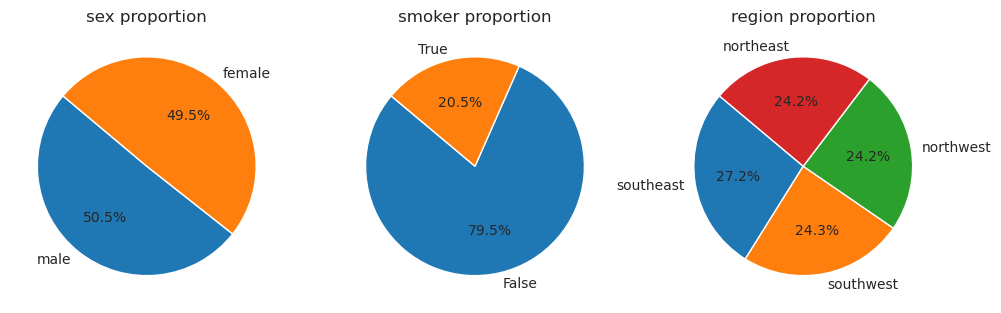

In [10]:
colum_names = df.select_dtypes(include=["object", "boolean"]).columns

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
axes = axes.flatten()

for ax, column in zip(axes, colum_names):
  cat_data = df[column].value_counts()
  ax.pie(
    x=cat_data,
    labels=cat_data.index,
    autopct="%1.1f%%",
    startangle=140
  )
  ax.set_title(f"{column} proportion")


**Observaciones**
- Las variables `sex` y `region` cuentan con proporciones similares entre sus respectivas categorías. 
- En genral contamos con datos mayormente de paciones NO fumadores.


Me surge la pregunta, ¿cómo es la propocion de estas variables en relación con las otras variables categóricas?
- De entre las personas que son fumadoras, ¿cuantas son hombres y cuantas mujeres? 
- ¿Cuál es la proporción de personas fumadoras por región?
- ¿Cuál es la proporción de hombres y mujeres por región?

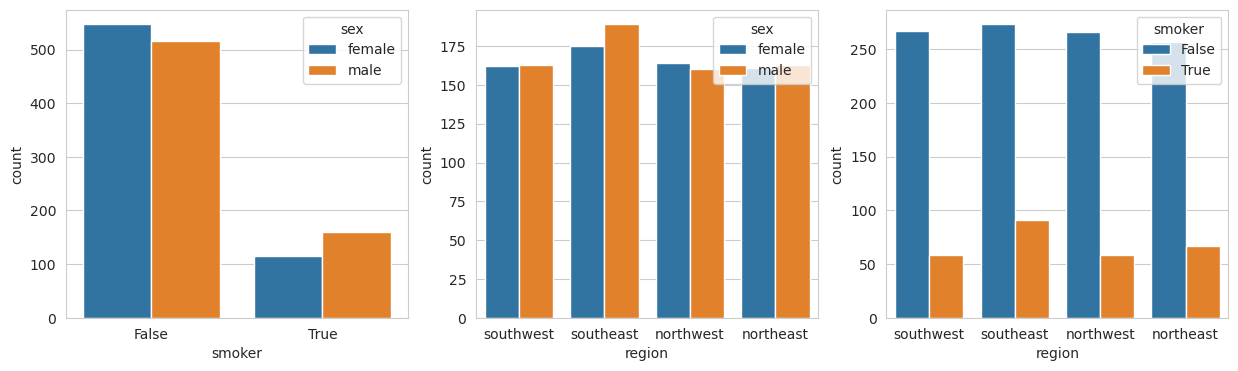

In [ ]:
combinations = [
  { "col": "smoker", "hue": "sex"},
  { "col": "region", "hue": "sex"},
  { "col": "region", "hue": "smoker"}
]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

axes=axes.flatten()

for ax, comb in zip(axes, combinations):
  sns.countplot(
    data=df,
    x=comb["col"],
    hue=comb["hue"],
    ax=ax
  )

**Observaciones**
- La proporción general de `smoker`, `region` y `sex` es muy similar a que si las segmentamos por las otras variables vategóricas.

¿Cuál es la distribución de las variables numéricas?

,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.0000,27.000,39.0000,51.00000,64.00000
bmi,1337.0,30.663452,6.100468,15.9600,26.290,30.4000,34.70000,53.13000
children,1337.0,1.095737,1.205571,0.0000,0.000,1.0000,2.00000,5.00000
charges,1337.0,13279.121487,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801


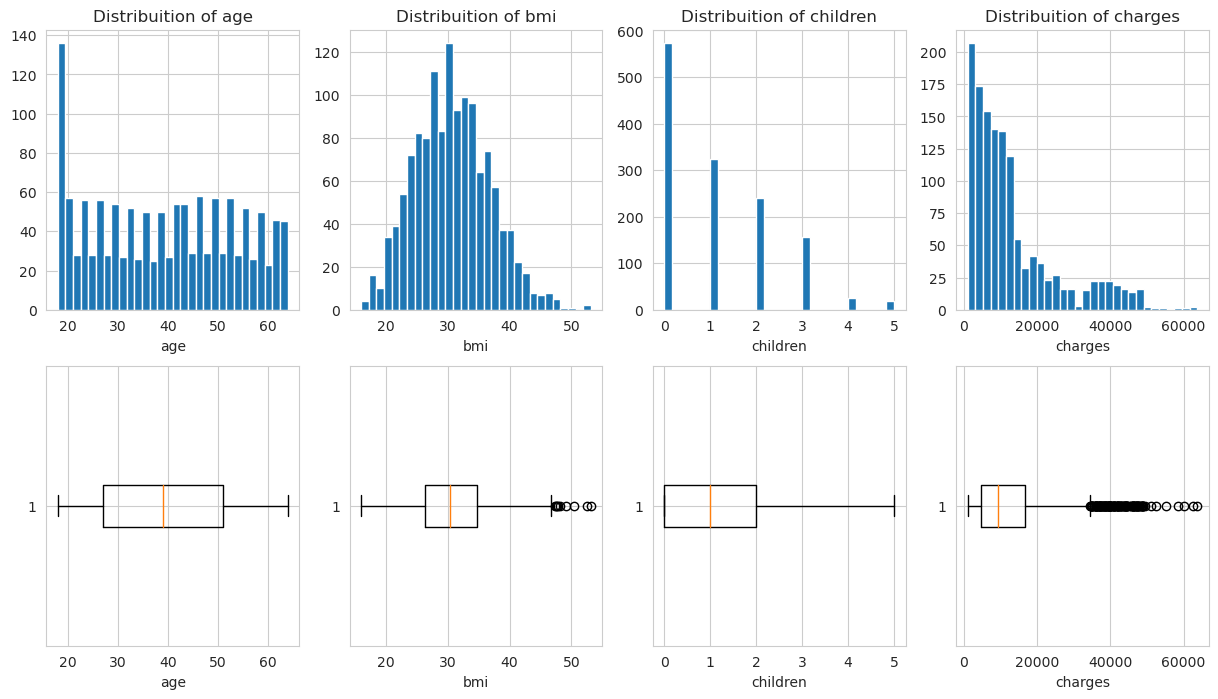

In [46]:
number_columns = df.select_dtypes(include=np.number).columns

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,8))
# axes = axes.flatten()
ncol = 0
for name in number_columns:
  axes[0, ncol].hist(
    x=df[name],
    bins=30
  )
  axes[0, ncol].set_title(f"Distribuition of {name}")
  axes[0, ncol].set_xlabel(name)
  
  axes[1, ncol].boxplot(
    x=df[name],
    vert=False
  )
  axes[1, ncol].set_xlabel(name)
  
  ncol+=1
  
  
df.describe().T

**Observaciones**
- La variable a predecir (`charges`) tiene una distribución asímetrica Positiva. 
- Los datos atípicos en `charges` se encuentran arriva arriva de los $50,000.
- `bmi` sigue una distribución normal con datos atípicos concentrados a partir de los 48-19 bmi.

Para confirmar los valores atipicos en `charges` vamos hacer un zoom in a su distirbución:

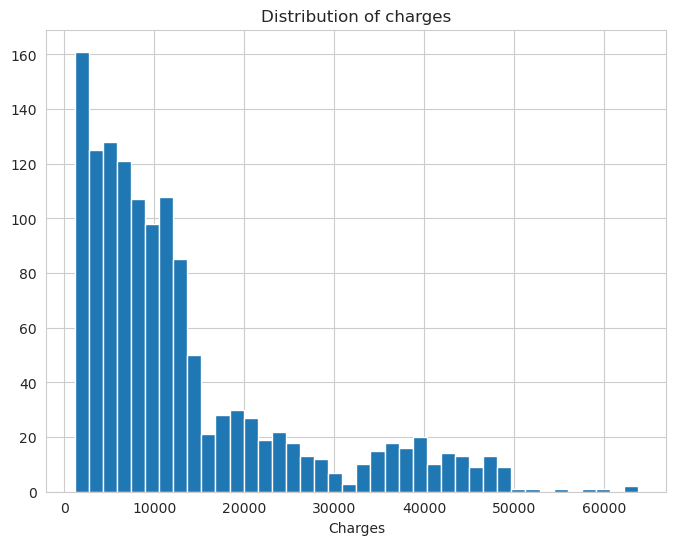

In [51]:
plt.figure(figsize=(8,6))
plt.hist(
  x=df["charges"],
  bins=40
)
plt.title("Distribution of charges")
plt.xlabel("Charges");

In [58]:
display(
  df[df["charges"] > 50_000].sort_values(by="charges"),
  df[df["charges"] > 50_000].shape
)

,age,sex,bmi,children,smoker,region,charges
34,28,male,36.400,1,True,southwest,51194.55914
1146,60,male,32.800,0,True,southwest,52590.82939
819,33,female,35.530,0,True,northwest,55135.40209
577,31,female,38.095,1,True,northeast,58571.07448
1230,52,male,34.485,3,True,northwest,60021.39897
1300,45,male,30.360,0,True,southeast,62592.87309
543,54,female,47.410,0,True,southeast,63770.42801


(7, 7)

📢 Para fines didacticos, y al ser solo 7 rows con valores atípicos, se procederan a eliminar.

In [59]:
df =df[df["charges"] < 50_000]